Identity Fraud - Modeling

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

# Feature Selection
We currently have 2000+ features, which cannot all used to develop ML models because of the curse of high dimensionality. Therefore, we need to narrow down this to some most useful features. The process is:

(1) Filter out 400 features with the highest Kolmogorov–Smirnov score. 

(2) Conduct step-wise selection on the 400 filtered features, assessing the performance based on different number of features to decide the optimal number of features for model development

## Filtering

In [2]:
# Expert recommends set num_filter to be about 10 to 20% of the original # variables
num_filter = 400
# Expert recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 25
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

In [3]:
%%time
# Read features data
df = pd.read_parquet('/Users/tomvdo29/Desktop/Projects/Fraud_Models/Identity/Data/FINAL.parquet')

# Read label data
data = pd.read_csv('/Users/tomvdo29/Desktop/Projects/Fraud_Models/Identity/Data/applications data.csv')

df['fraud_label'] = data.fraud_label
del data

CPU times: user 7.58 s, sys: 16.2 s, total: 23.8 s
Wall time: 10.3 s


In [4]:
# Preprocessing the data
df = df.set_index(index_name) 
df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed

In [5]:
df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
goods = df[df[y_name] == 0]
bads = df[df[y_name] == 1]
del df
num_goods = len(goods)
num_bads = len(bads)
num_vars = len(bads.columns)-2

In [6]:
%%time
if(balance != 0):
    num_goods_desired = int(min(num_goods,num_bads*balance))
    goods = goods.sample(n=num_goods_desired,random_state=1)
    goods_keep = list(goods.index)
    goods_keep.sort()
df_sampled = pd.concat([goods,bads])
df_sampled.sort_index(inplace=True)


CPU times: user 1.75 s, sys: 6.65 s, total: 8.4 s
Wall time: 13.9 s


In [7]:
# Define filter function

def filter(num_filter,goods,bads):
    column_names = ['variable','filter score']   
    filter_score = pd.DataFrame(columns=column_names)

    j = 0
    for column in goods:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)
    return filter_score

In [8]:
# Run filter function and export filtered set of variables
filter_score = filter(num_filter,goods,bads)
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
filter_score

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


,variable,filter score
2101,fraud_label,1.0
8,address_day_since,0.33414
43,fulladdress_day_since,0.333269
14,address_count_30,0.332648
49,fulladdress_count_30,0.331969
...,...,...
1169,fullname_fulladdress_unique_count_for_zip5_30,0.000001
1646,ssn_lastname_unique_count_for_fullname_0,0.000001
2064,ssn_fulladdress_unique_count_for_ssn_firstname_60,0.000001
1015,fulladdress_unique_count_for_address_0,0.0


In [9]:
Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)

# Subset of the data with the filtered set of features
df_top = df_sampled.loc[:,vars_keep]

# delete these before starting the next file, if any
del goods
del bads
gc.collect()

0

In [10]:
filter_score.head(100).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'])
print(' vars_keep:',vars_keep)

 vars_keep: ['fraud_label', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_fullname_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_fullname_dob_homephone_60', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_60', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_fullname_60', 'fulladdress_unique_count_for_fullname_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_fullname_dob_homephone_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_fullname_dob_60', 'address_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_lastname_60', 'address_unique_count_for_fullname_60', 'fulladdress_unique_count_for_ssn_fullname_60', 'fulladdress_unique_count_for

In [11]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.shape
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,address_unique_count_for_fullname_homephone_60,address_count_0_by_30,...,fulladdress_homephone_unique_count_for_dob_60,fullname_dob_unique_count_for_address_60,fullname_dob_unique_count_for_fulladdress_60,ssn_firstname_unique_count_for_fullname_fulladdress_60,ssn_firstname_unique_count_for_fulladdress_60,fullname_dob_unique_count_for_ssn_homephone_60,ssn_unique_count_for_fullname_homephone_60,fulladdress_homephone_unique_count_for_ssn_fullname_30,homephone_count_30,fulladdress_homephone_unique_count_for_ssn_zip5_30
record,,,,,,,,,,,,,,,,,,,,,
38511.0,0.0,0.0,12.0,12.0,12.0,12.0,8.0,8.0,12.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
38512.0,365.0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0
38513.0,365.0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0
38514.0,365.0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
38515.0,365.0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)

In [13]:
X = df_keep

In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:05:42.671209


In [15]:
print(X.shape,Y.shape)

(794997, 400) (794997, 1)


In [16]:
del df_top
del vars_keep_df

## Step-wise Selection


In [17]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, 1]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
    
    # Sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff


    temp_df = pd.DataFrame()
    temp_df["pred_prob"] = y_prob
    temp_df["fraud"] = y

    output = temp_df.sort_values(by='pred_prob', ascending=False).iloc[0:int(len(y) * detect_rate), 1:].fraud.sum()/ num_fraud   
    
    # Return the FDR score (#fraud_in_cutoff / #total_fraud) as output
    return output

In [18]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=4, verbose = -1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y.values.ravel())

CPU times: user 22.6 s, sys: 36.5 s, total: 59.1 s
Wall time: 1h 41min 20s


SequentialFeatureSelector(cv=4,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=4, verbose=-1),
                          k_features=(25, 25), n_jobs=-1,
                          scoring=<function fdr at 0x174125940>)

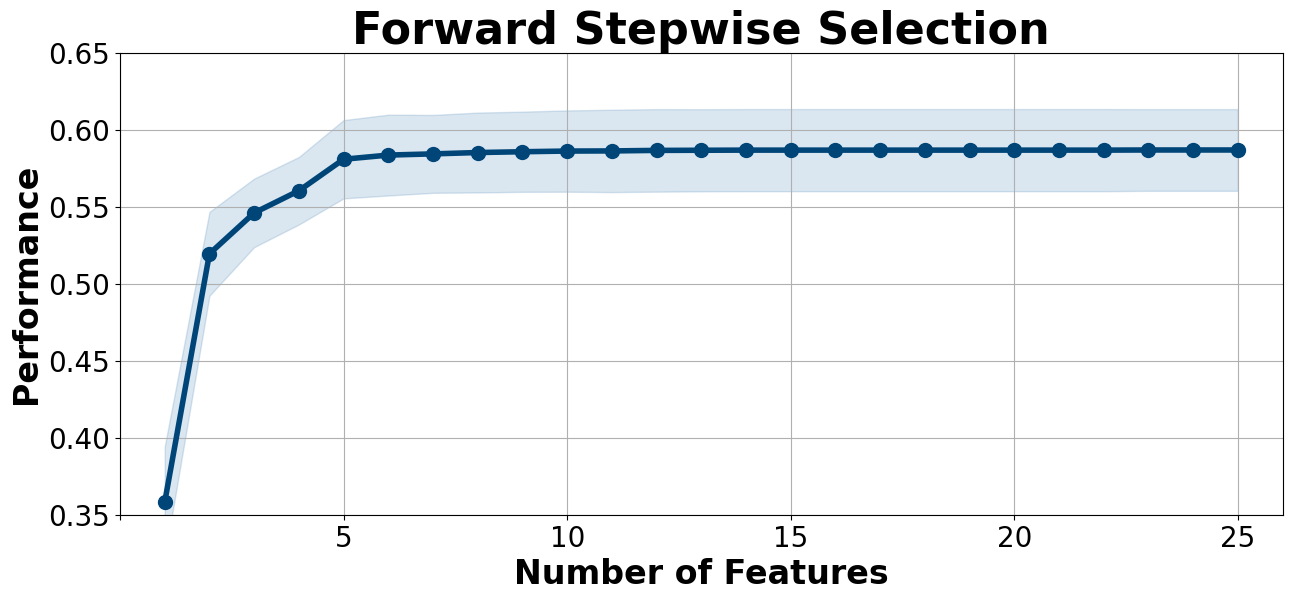

In [65]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1, ax = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6), color = '#004578')
plt.xticks(np.arange(0, len(X.columns)+1, step=5))
plt.yticks(np.arange(0.35,0.65,step=.05))
plt.ylim([0.35, 0.65])
plt.xlim(0,num_wrapper+1)
plt.title('Forward Stepwise Selection',fontsize = 32, fontweight="bold")
plt.grid()
plt.xlabel('Number of Features', fontsize=24, fontweight="bold")
plt.ylabel('Performance', fontsize=24, fontweight="bold")
plt.tick_params(axis='both', which='major', labelsize=20)

# Set properties for each line in the plot
for line in ax.lines:
    line.set_linewidth(4)   # Set line width
    line.set_markersize(10) # Set marker size


plt.savefig('performance_nvars.png')
plt.show()

In [47]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS["change%"] = vars_FS.avg_score.diff()
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,change%
1,"(1,)","[0.30571030640668523, 0.407033426183844, 0.366...",0.358231,"(fulladdress_day_since,)",0.05793,0.036139,0.020865,NaN
2,"(1, 385)","[0.4738857938718663, 0.528899721448468, 0.5459...",0.519458,"(fulladdress_day_since, ssn_dob_unique_count_f...",0.043613,0.027208,0.015708,0.161227
3,"(1, 322, 385)","[0.5090529247910863, 0.5539693593314763, 0.568...",0.546009,"(fulladdress_day_since, homephone_unique_count...",0.035667,0.02225,0.012846,0.026551
4,"(1, 268, 322, 385)","[0.5233286908077994, 0.5703342618384402, 0.580...",0.560373,"(fulladdress_day_since, ssn_lastname_count_0_b...",0.035149,0.021927,0.01266,0.014364
5,"(1, 202, 268, 322, 385)","[0.5379526462395543, 0.5860027855153204, 0.597...",0.580832,"(fulladdress_day_since, zip5_unique_count_for_...",0.040758,0.025426,0.01468,0.020459
6,"(1, 47, 202, 268, 322, 385)","[0.5393454038997214, 0.5884401114206128, 0.601...",0.583531,"(fulladdress_day_since, fulladdress_unique_cou...",0.042066,0.026242,0.015151,0.002699
7,"(1, 47, 197, 202, 268, 322, 385)","[0.541782729805014, 0.5887883008356546, 0.6016...",0.584315,"(fulladdress_day_since, fulladdress_unique_cou...",0.040543,0.025292,0.014602,0.000783
8,"(1, 16, 47, 197, 202, 268, 322, 385)","[0.541782729805014, 0.5891364902506964, 0.6023...",0.585185,"(fulladdress_day_since, address_unique_count_f...",0.041573,0.025935,0.014974,0.000871
9,"(1, 16, 47, 197, 202, 268, 322, 344, 385)","[0.541782729805014, 0.591225626740947, 0.60236...",0.585707,"(fulladdress_day_since, address_unique_count_f...",0.041726,0.02603,0.015029,0.000522
10,"(1, 16, 47, 128, 197, 202, 268, 322, 344, 385)","[0.541782729805014, 0.591225626740947, 0.60236...",0.586143,"(fulladdress_day_since, address_unique_count_f...",0.042322,0.026402,0.015243,0.000435


In [48]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,change%,add variables in this order,variable name
1,"(1,)","[0.30571030640668523, 0.407033426183844, 0.366...",0.358231,"(fulladdress_day_since,)",0.05793,0.036139,0.020865,NaN,1.0,fulladdress_day_since
2,"(1, 385)","[0.4738857938718663, 0.528899721448468, 0.5459...",0.519458,"(fulladdress_day_since, ssn_dob_unique_count_f...",0.043613,0.027208,0.015708,0.161227,2.0,ssn_dob_unique_count_for_fullname_homephone_60
3,"(1, 322, 385)","[0.5090529247910863, 0.5539693593314763, 0.568...",0.546009,"(fulladdress_day_since, homephone_unique_count...",0.035667,0.02225,0.012846,0.026551,3.0,homephone_unique_count_for_ssn_zip5_7
4,"(1, 268, 322, 385)","[0.5233286908077994, 0.5703342618384402, 0.580...",0.560373,"(fulladdress_day_since, ssn_lastname_count_0_b...",0.035149,0.021927,0.01266,0.014364,4.0,ssn_lastname_count_0_by_30
5,"(1, 202, 268, 322, 385)","[0.5379526462395543, 0.5860027855153204, 0.597...",0.580832,"(fulladdress_day_since, zip5_unique_count_for_...",0.040758,0.025426,0.01468,0.020459,5.0,zip5_unique_count_for_fullname_homephone_3
6,"(1, 47, 202, 268, 322, 385)","[0.5393454038997214, 0.5884401114206128, 0.601...",0.583531,"(fulladdress_day_since, fulladdress_unique_cou...",0.042066,0.026242,0.015151,0.002699,6.0,fulladdress_unique_count_for_ssn_fullname_30
7,"(1, 47, 197, 202, 268, 322, 385)","[0.541782729805014, 0.5887883008356546, 0.6016...",0.584315,"(fulladdress_day_since, fulladdress_unique_cou...",0.040543,0.025292,0.014602,0.000783,7.0,ssn_fullname_count_30
8,"(1, 16, 47, 197, 202, 268, 322, 385)","[0.541782729805014, 0.5891364902506964, 0.6023...",0.585185,"(fulladdress_day_since, address_unique_count_f...",0.041573,0.025935,0.014974,0.000871,8.0,address_unique_count_for_ssn_homephone_60
9,"(1, 16, 47, 197, 202, 268, 322, 344, 385)","[0.541782729805014, 0.591225626740947, 0.60236...",0.585707,"(fulladdress_day_since, address_unique_count_f...",0.041726,0.02603,0.015029,0.000522,9.0,fulladdress_homephone_unique_count_for_ssn_fir...
10,"(1, 16, 47, 128, 197, 202, 268, 322, 344, 385)","[0.541782729805014, 0.591225626740947, 0.60236...",0.586143,"(fulladdress_day_since, address_unique_count_f...",0.042322,0.026402,0.015243,0.000435,10.0,address_unique_count_for_fullname_homephone_3


In [91]:
ordered_vars_FS.loc[15,"feature_names"]

('fulladdress_day_since',
 'address_count_14',
 'address_count_7',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_fullname_30',
 'address_unique_count_for_fullname_homephone_3',
 'ssn_fullname_count_30',
 'zip5_unique_count_for_fullname_homephone_3',
 'ssn_lastname_count_0_by_30',
 'homephone_unique_count_for_ssn_zip5_7',
 'fulladdress_homephone_unique_count_for_ssn_firstname_60',
 'ssn_unique_count_for_fulladdress_homephone_60',
 'ssn_dob_unique_count_for_fullname_homephone_60',
 'ssn_lastname_unique_count_for_zip5_60')

In [49]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [82]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                                 fulladdress_day_since
2        ssn_dob_unique_count_for_fullname_homephone_60
3                 homephone_unique_count_for_ssn_zip5_7
4                            ssn_lastname_count_0_by_30
5            zip5_unique_count_for_fullname_homephone_3
6          fulladdress_unique_count_for_ssn_fullname_30
7                                 ssn_fullname_count_30
8             address_unique_count_for_ssn_homephone_60
9     fulladdress_homephone_unique_count_for_ssn_fir...
10        address_unique_count_for_fullname_homephone_3
11             address_unique_count_for_ssn_lastname_60
12                ssn_lastname_unique_count_for_zip5_60
13                                     address_count_14
14        ssn_unique_count_for_fulladdress_homephone_60
15                                      address_count_7
16                                address_count_0_by_30
17                            fulladdress_count_0_by_30
18    fulladdress_unique_count_for_fullname_dob_

In [54]:
filter_score = filter_score.iloc[1:,:]
filter_score

,variable,filter score
8,address_day_since,0.33414
43,fulladdress_day_since,0.333269
14,address_count_30,0.332648
49,fulladdress_count_30,0.331969
13,address_count_14,0.322436
...,...,...
1169,fullname_fulladdress_unique_count_for_zip5_30,0.000001
1646,ssn_lastname_unique_count_for_fullname_0,0.000001
2064,ssn_fulladdress_unique_count_for_ssn_firstname_60,0.000001
1015,fulladdress_unique_count_for_address_0,0.0


In [3]:
vars_keep_sorted = filter_score[filter_score.variable.isin(vars_keep_list)]
vars_keep_sorted

NameError: name 'filter_score' is not defined

In [2]:
# vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['wrapper order'] = vars_keep_sorted.index + 1
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

NameError: name 'vars_keep_sorted' is not defined

In [83]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['fulladdress_day_since',
 'ssn_dob_unique_count_for_fullname_homephone_60',
 'homephone_unique_count_for_ssn_zip5_7',
 'ssn_lastname_count_0_by_30',
 'zip5_unique_count_for_fullname_homephone_3',
 'fulladdress_unique_count_for_ssn_fullname_30',
 'ssn_fullname_count_30',
 'address_unique_count_for_ssn_homephone_60',
 'fulladdress_homephone_unique_count_for_ssn_firstname_60',
 'address_unique_count_for_fullname_homephone_3',
 'address_unique_count_for_ssn_lastname_60',
 'ssn_lastname_unique_count_for_zip5_60',
 'address_count_14',
 'ssn_unique_count_for_fulladdress_homephone_60',
 'address_count_7',
 'address_count_0_by_30',
 'fulladdress_count_0_by_30',
 'fulladdress_unique_count_for_fullname_dob_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_60',
 'address_unique_count_for_ssn_60',
 'address_unique_count_for_fullname_dob_60',
 'fulladdress_unique_count_for_fullname_dob_homephone_30',
 'address_unique_count_for_ssn_zip5_30',
 'address_unique_count_for_fullname_dob_homephon

In [9]:
%%time
# Read features data
df = pd.read_parquet('/Users/tomvdo29/Desktop/Projects/Fraud_Models/Identity/Data/FINAL.parquet')

# Read label data
data = pd.read_csv('/Users/tomvdo29/Desktop/Projects/Fraud_Models/Identity/Data/applications data.csv')

df['fraud_label'] = data.fraud_label
del data
df.shape

CPU times: user 7.65 s, sys: 21.3 s, total: 28.9 s
Wall time: 10.8 s
CPU times: user 7.65 s, sys: 21.3 s, total: 28.9 s
Wall time: 10.8 s


(1000000, 2103)

In [96]:
picked_vars_list = list(ordered_vars_FS.loc[15,"feature_names"])
picked_vars_list.append(index_name)
picked_vars_list.append(y_name)
picked_vars_list

['fulladdress_day_since',
 'address_count_14',
 'address_count_7',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_fullname_30',
 'address_unique_count_for_fullname_homephone_3',
 'ssn_fullname_count_30',
 'zip5_unique_count_for_fullname_homephone_3',
 'ssn_lastname_count_0_by_30',
 'homephone_unique_count_for_ssn_zip5_7',
 'fulladdress_homephone_unique_count_for_ssn_firstname_60',
 'ssn_unique_count_for_fulladdress_homephone_60',
 'ssn_dob_unique_count_for_fullname_homephone_60',
 'ssn_lastname_unique_count_for_zip5_60',
 'record',
 'fraud_label']

In [10]:
picked_vars_list = ['fulladdress_day_since',
 'address_count_14',
 'address_count_7',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_fullname_30',
 'address_unique_count_for_fullname_homephone_3',
 'ssn_fullname_count_30',
 'zip5_unique_count_for_fullname_homephone_3',
 'ssn_lastname_count_0_by_30',
 'homephone_unique_count_for_ssn_zip5_7',
 'fulladdress_homephone_unique_count_for_ssn_firstname_60',
 'ssn_unique_count_for_fulladdress_homephone_60',
 'ssn_dob_unique_count_for_fullname_homephone_60',
 'ssn_lastname_unique_count_for_zip5_60',
 'record',
 'fraud_label']
picked_vars_list

['fulladdress_day_since',
 'address_count_14',
 'address_count_7',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_fullname_30',
 'address_unique_count_for_fullname_homephone_3',
 'ssn_fullname_count_30',
 'zip5_unique_count_for_fullname_homephone_3',
 'ssn_lastname_count_0_by_30',
 'homephone_unique_count_for_ssn_zip5_7',
 'fulladdress_homephone_unique_count_for_ssn_firstname_60',
 'ssn_unique_count_for_fulladdress_homephone_60',
 'ssn_dob_unique_count_for_fullname_homephone_60',
 'ssn_lastname_unique_count_for_zip5_60',
 'record',
 'fraud_label']

In [1]:
vars_keep_sorted

NameError: name 'vars_keep_sorted' is not defined

In [11]:
df_keep = df.filter(picked_vars_list, axis=1)
df_keep.shape

(1000000, 17)

In [12]:
df_keep.to_csv('FS_vars_final.csv',index=False)

In [102]:
del df

In [ ]:
%%time
# Backward Stepwise Selection
sfs_bw = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs_bw.fit(X,Y.values.ravel())

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1, ax = plot_sfs(sfs_bw.get_metric_dict(),kind='std_dev', figsize=(15, 6), color = '#004578')
plt.xticks(np.arange(0, len(X.columns)+1, step=5))
plt.yticks(np.arange(0.35,0.65,step=.05))
plt.ylim([0.35, 0.65])
plt.xlim(0,num_wrapper+1)
plt.title('Forward Stepwise Selection',fontsize = 32, fontweight="bold")
plt.grid()
plt.xlabel('Number of Features', fontsize=24, fontweight="bold")
plt.ylabel('Performance', fontsize=24, fontweight="bold")
plt.tick_params(axis='both', which='major', labelsize=20)

# Set properties for each line in the plot
for line in ax.lines:
    line.set_linewidth(4)   # Set line width
    line.set_markersize(10) # Set marker size


plt.savefig('performance_nvars.png')
plt.show()

# Machine Learning Models
This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('FS_vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 17)
CPU times: user 412 ms, sys: 52.4 ms, total: 465 ms
Wall time: 472 ms


,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,2.0,1
2,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,3.0,0
3,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,4.0,0
4,365.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,5.0,0


In [3]:
vars.describe()

,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60,record,fraud_label
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.054768,1.042577,1.066676,1.063742,1.036330,1.029817,1.048872,2.157959,29.544037,1.925236,1.022219,1.027643,1.021865,1.021071,500000.500000,0.014393
std,99.097485,0.618082,0.585789,0.701785,0.699411,0.608106,0.541356,0.499019,1.490782,2.655220,1.206167,0.479612,0.517816,0.468926,0.467894,288675.278933,0.119104
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.363636,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,250000.750000,0.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,30.000000,2.000000,1.000000,1.000000,1.000000,1.000000,500000.500000,0.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,30.000000,2.000000,1.000000,1.000000,1.000000,1.000000,750000.250000,0.000000
max,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,34.000000,34.000000,30.000000,33.000000,30.000000,34.000000,34.000000,34.000000,1000000.000000,1.000000


In [4]:
record_save = vars['record']
Y_save = pd.DataFrame(vars.loc[:,'fraud_label'])
Y_save.head()

,fraud_label
0,0
1,1
2,0
3,0
4,0


## Scale and truncate field values

In [5]:
X_no_scaling = vars.drop(columns = ['record','fraud_label'])
X_no_scaling.describe()

,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.054768,1.042577,1.066676,1.063742,1.036330,1.029817,1.048872,2.157959,29.544037,1.925236,1.022219,1.027643,1.021865,1.021071
std,99.097485,0.618082,0.585789,0.701785,0.699411,0.608106,0.541356,0.499019,1.490782,2.655220,1.206167,0.479612,0.517816,0.468926,0.467894
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.363636,1.000000,1.000000,1.000000,1.000000,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,30.000000,2.000000,1.000000,1.000000,1.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,30.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,34.000000,34.000000,30.000000,33.000000,30.000000,34.000000,34.000000,34.000000


In [6]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.217728e-16,1.161098e-16,-1.432880e-16,7.727152e-17,3.240075e-17,3.945289e-17,5.162359e-17,-3.970158e-17,1.289280e-17,2.803606e-15,2.371436e-17,3.492495e-17,-1.699192e-16,-3.645795e-17,-1.260467e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-8.860966e-02,-7.268319e-02,-9.500910e-02,-9.113671e-02,-5.974291e-02,-5.507837e-02,-9.793619e-02,-7.767462e-01,-1.061321e+01,-7.670881e-01,-4.632704e-02,-5.338386e-02,-4.662787e-02,-4.503366e-02
25%,4.030326e-01,-8.860966e-02,-7.268319e-02,-9.500910e-02,-9.113671e-02,-5.974291e-02,-5.507837e-02,-9.793619e-02,-7.767462e-01,1.717233e-01,-7.670881e-01,-4.632704e-02,-5.338386e-02,-4.662787e-02,-4.503366e-02
50%,4.030326e-01,-8.860966e-02,-7.268319e-02,-9.500910e-02,-9.113671e-02,-5.974291e-02,-5.507837e-02,-9.793619e-02,-1.059572e-01,1.717233e-01,6.198481e-02,-4.632704e-02,-5.338386e-02,-4.662787e-02,-4.503366e-02
75%,4.030326e-01,-8.860966e-02,-7.268319e-02,-9.500910e-02,-9.113671e-02,-5.974291e-02,-5.507837e-02,-9.793619e-02,5.648318e-01,1.717233e-01,6.198481e-02,-4.632704e-02,-5.338386e-02,-4.662787e-02,-4.503366e-02
max,4.030326e-01,4.683076e+01,4.943321e+01,4.122816e+01,4.137234e+01,4.762934e+01,5.351411e+01,6.603184e+01,2.135929e+01,1.717233e-01,2.576324e+01,6.041923e+01,6.367585e+01,7.032702e+01,7.048369e+01


In [7]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization
Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [15]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

### Ridge

In [16]:
alphas = 10**np.linspace(2,9,30)*0.5

In [17]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [18]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 15)

CPU times: user 721 ms, sys: 13.5 ms, total: 734 ms
Wall time: 272 ms


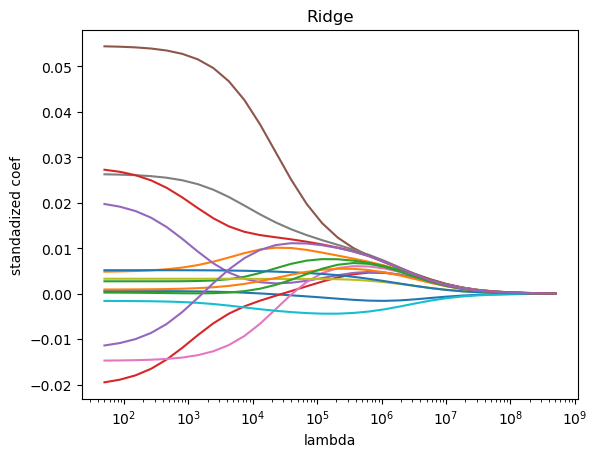

In [19]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

### Lasso

In [20]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [21]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: user 21min 6s, sys: 46.7 s, total: 21min 52s
Wall time: 2min 21s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


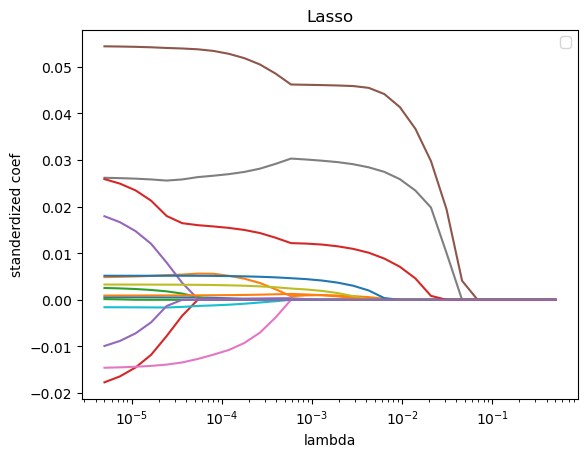

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

### Look at PCA

In [47]:
print(len(X_trntst.columns))
X_trntst_save = X_trntst.copy()

15


In [62]:
pca.explained_variance_ratio_

array([4.41857699e-01, 2.54930054e-01, 9.17042592e-02, 6.25294500e-02,
       5.91742663e-02, 3.05026117e-02, 2.55621338e-02, 1.74088410e-02,
       8.28456448e-03, 3.29356484e-03, 2.39463285e-03, 1.03675973e-03,
       8.40821957e-04, 3.40824146e-04, 1.39517380e-04])

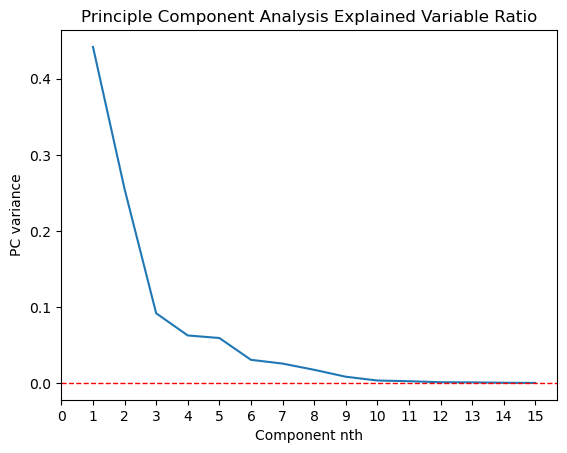

In [69]:
pca = PCA(svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(np.arange(1, len(X_trntst.columns)+1, step=1),pca.explained_variance_ratio_)
plt.xlabel('Component nth')
plt.ylabel('PC variance')
plt.title('Principle Component Analysis Explained Variable Ratio')
plt.xticks(np.arange(0, len(X_trntst.columns)+1, step=1))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns), linestyle='--', color='red', linewidth=1)
X_trntst = X_trntst_save.copy()

In [70]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 10, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.457155,-0.168474,0.264517,0.709428,-0.72335,-0.147820,-0.226692,-0.068164,-0.002101,-0.010038
1,-0.457155,-0.168474,0.264517,0.709428,-0.72335,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038
2,-0.457156,-0.168474,0.264517,0.709428,-0.72335,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038
3,-0.457156,-0.168474,0.264517,0.709428,-0.72335,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038
4,-0.457156,-0.168474,0.264517,0.709428,-0.72335,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038


In [71]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
833507,0.101234,-0.005299,-1.316363,-0.137690,0.617794,1.580685,0.003794,-0.061321,-0.068517,-0.039573
833508,-0.457156,-0.168474,0.264517,0.709428,-0.723350,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038
833509,1.442006,2.479369,-5.797548,-0.982043,2.701531,-1.652423,0.248040,0.266572,0.037333,0.421404
833510,-0.457156,-0.168474,0.264517,0.709428,-0.723350,-0.147819,-0.226692,-0.068164,-0.002101,-0.010038
833511,-0.250146,-0.179512,0.331912,0.716300,0.593240,-0.133913,-0.192357,0.062771,-0.003615,0.005984


In [73]:
X_trntst.describe()

,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.031522,0.000682,0.001052,-0.000390,-0.000261,0.000864,0.001317,-0.001758,-0.000505,0.001229,-0.001086,-0.000104,-0.001758,-0.001404,-0.001305
std,0.981263,1.007653,1.011013,0.996882,0.997339,1.005772,1.013504,0.979547,1.003604,0.995898,0.998835,0.990696,0.972460,0.977878,0.977883
min,-3.280209,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,-0.097936,-0.776746,-10.613206,-0.767088,-0.046327,-0.053384,-0.046628,-0.045034
25%,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,-0.097936,-0.776746,0.171723,-0.767088,-0.046327,-0.053384,-0.046628,-0.045034
50%,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,-0.097936,-0.105957,0.171723,0.061985,-0.046327,-0.053384,-0.046628,-0.045034
75%,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,-0.097936,0.564832,0.171723,0.061985,-0.046327,-0.053384,-0.046628,-0.045034
max,0.403033,46.830762,49.433212,41.228162,41.372336,47.629338,53.514114,66.031835,21.359291,0.171723,23.276026,58.334213,63.675850,70.327021,70.483691


In [74]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.013149,0.033934,-0.131688,-0.012227,0.006402,0.132550,0.001785,0.002979,-0.003074,-0.003384
std,2.494592,2.180180,1.225316,0.945207,0.934594,0.768894,0.608356,0.535987,0.451134,0.257466
min,-0.457156,-4.606745,-10.385530,-24.678083,-9.453077,-7.378456,-19.275179,-11.755477,-4.190056,-6.231355
25%,-0.343994,-0.181012,0.080442,-0.161890,-0.723350,-0.156320,-0.209524,-0.100235,-0.005175,-0.010038
50%,-0.230832,-0.173993,0.299699,-0.077167,-0.082689,-0.142414,-0.021253,-0.066839,-0.002148,-0.001744
75%,-0.033479,-0.150447,0.365610,0.709428,0.575606,-0.120007,0.171814,0.030700,-0.000634,0.013994
max,131.021711,111.551118,24.323716,15.312245,18.385810,18.007394,18.364150,26.834182,41.674717,14.553883


In [75]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [76]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,-3.341697e-18,-1.670848e-18,2.182332e-17,2.632439e-17,8.439489e-18,-8.729330e-18,1.866917e-18,-1.658061e-18,1.960689e-19,-8.013252e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.786272e-01,-2.283692e+00,-9.180418e+00,-2.324322e+01,-1.193189e+01,-1.230820e+01,-3.301336e+01,-3.939038e+01,-1.356981e+01,-3.336763e+01
25%,-1.381841e-01,-9.380457e-02,2.268733e-01,-1.635396e-01,-7.723371e-01,-2.324722e-01,-3.403771e-01,-1.973155e-01,-8.288672e-03,-4.542739e-02
50%,-9.396764e-02,-8.950487e-02,2.570483e-01,-8.015195e-02,-8.828875e-02,-2.198305e-01,-3.452607e-02,-1.289640e-01,-5.995458e-03,-7.890961e-03
75%,-1.685484e-02,-8.666574e-02,3.148525e-01,7.368697e-01,6.145876e-01,-2.014507e-01,1.666335e-01,6.043379e-02,-1.809330e-03,6.461699e-02
max,4.939214e+01,6.781093e+01,2.402677e+01,2.500998e+01,2.240375e+01,2.651397e+01,4.228164e+01,6.574843e+01,1.224659e+02,8.243621e+01


## Subsample the larger class if desired

In [8]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['fraud_label'] = Y_trntst['fraud_label']
temp.head()
goods = temp[temp['fraud_label']==0]
bads = temp[temp['fraud_label']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['fraud_label'])
X_trntst_sampled = all_sampled.drop(columns=['fraud_label'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 15) 23841


In [15]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Modeling

In [59]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0
Modeling_output

,Model,Trn,Tst,OOT
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
995,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN


In [60]:
def run_model(model, model_type):
    global counter, model_counter
    FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
     
        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        model.fit(X_trn, Y_trn.values.ravel())   
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['fraud_label'] = Y_trn_save['fraud_label']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'fraud_label']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'fraud_label'])
    
        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['fraud_label'] = Y_tst['fraud_label']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'fraud_label']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'fraud_label'])
    
        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['fraud_label'] = Y_oot['fraud_label']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'fraud_label']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'fraud_label'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        Modeling_output.iloc[counter] = [model_type,FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1
        
    print(FDR3.mean())
    model_counter = model_counter + 1


### Logistic Regression

In [61]:
%%time
# Logistic regression
{'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}
model = LogisticRegression(max_iter=100, 
                               penalty = 'l2' ,
                               C = 0.5 , 
                               solver = 'lbfgs',
                               l1_ratio = None)

run_model(model, "Logistic\nRegression")

0 0.5393151175277413 0.5430226144511858 0.5159262363788768
1 0.5437908496732026 0.5281180400890868 0.5146689019279128
2 0.5419439163498099 0.5363408521303258 0.5163453478625314
3 0.5371462264150944 0.5418202438332861 0.5142497904442582
4 0.5452687267043405 0.5338753387533876 0.5163453478625314
5 0.5378580767859266 0.5392320534223706 0.5134115674769488
6 0.5438617260565881 0.5362359550561798 0.5167644593461861
7 0.5446534889259348 0.5264616237184816 0.5146689019279128
8 0.5450242574843214 0.5284026996625422 0.5155071248952221
9 0.5427003816793893 0.5299475572729782 0.5146689019279128
trn    0.542156
tst    0.534346
oot    0.515256
dtype: float64
CPU times: user 1min 53s, sys: 1min 1s, total: 2min 55s
Wall time: 19.5 s


### Decision Tree

In [62]:
%%time
# Single DT
model = DecisionTreeClassifier(criterion = 'gini',
                                   max_depth=5,
                                   min_samples_split=50,
                                   min_samples_leaf=30)
 
run_model(model, "Decision\nTree")
Modeling_output

0 0.5377639899773297 0.53723110865968 0.512154233025985
1 0.5372283576772355 0.5317902955939766 0.5155071248952221
2 0.5338932923222525 0.536015756893641 0.5129924559932942
3 0.5379971590909091 0.5265524023602135 0.5159262363788768
4 0.5344052967604634 0.5376162299239222 0.5159262363788768
5 0.5385168323948724 0.5333333333333333 0.5129924559932942
6 0.5365999046256557 0.5319148936170213 0.5159262363788768
7 0.5355827491980516 0.5350974930362117 0.5129924559932942
8 0.5369429010521338 0.5315670800450958 0.5163453478625314
9 0.5446428571428571 0.5442195730523981 0.5222129086336965
trn    0.537357
tst    0.534534
oot    0.515298
dtype: float64
CPU times: user 3.83 s, sys: 1.5 s, total: 5.33 s
Wall time: 3.64 s


,Model,Trn,Tst,OOT
0,Logistic\nRegression,0.539315,0.543023,0.515926
1,Logistic\nRegression,0.543791,0.528118,0.514669
2,Logistic\nRegression,0.541944,0.536341,0.516345
3,Logistic\nRegression,0.537146,0.54182,0.51425
4,Logistic\nRegression,0.545269,0.533875,0.516345
...,...,...,...,...
995,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN


### Random Forest

In [63]:
model = RandomForestClassifier(n_estimators=50,
                                   max_depth=8,
                                   min_samples_split=50,
                                   min_samples_leaf=30,
                                   max_features = 10,
                                   criterion='entropy')

run_model(model, "Random\nForest")
Modeling_output

0 0.5798299197508684 0.5866593767085839 0.5532271584241408
1 0.5817751479289941 0.5858869834129885 0.5532271584241408
2 0.5833432339313295 0.5760445682451254 0.549455155071249
3 0.5841138114997037 0.5761478163493841 0.5511316010058676
4 0.5793209511416065 0.5906021384355655 0.5519698239731768
5 0.583672005737509 0.5781378742103818 0.5498742665549036
6 0.5798018383669571 0.5873278236914601 0.5507124895222129
7 0.5809478560399097 0.5822185061315496 0.5490360435875943
8 0.5831462002127408 0.5769881556683587 0.5502933780385583
9 0.5854033593565177 0.5778215592457079 0.5536462699077954
trn    0.582135
tst    0.581783
oot    0.551257
dtype: float64


,Model,Trn,Tst,OOT
0,Logistic\nRegression,0.539315,0.543023,0.515926
1,Logistic\nRegression,0.543791,0.528118,0.514669
2,Logistic\nRegression,0.541944,0.536341,0.516345
3,Logistic\nRegression,0.537146,0.54182,0.51425
4,Logistic\nRegression,0.545269,0.533875,0.516345
...,...,...,...,...
995,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN


### LightGBM

In [64]:
model = lgb.LGBMClassifier(n_estimators=50,
                               num_leaves=2,
                               max_depth = 100,
                               learning_rate = 0.1,
                               reg_alpha = 0.7,
                               reg_lambda = 0.3, verbose = -1)

run_model(model, "LightGBM")

0 0.5547977985163914 0.5653603727048506 0.5377200335289187
1 0.5574917022285444 0.5718286194343322 0.5377200335289187
2 0.5630033159639981 0.587426326129666 0.5423302598491199
3 0.5628878281622912 0.5607940446650124 0.5377200335289187
4 0.5589462391226606 0.5704809286898839 0.537300922045264
5 0.5559094125973106 0.5760838764522528 0.539815590947192
6 0.5628848886783515 0.5582374403592478 0.538558256496228
7 0.5671800947867298 0.5480796187272218 0.539815590947192
8 0.5638537104982838 0.5559302979201799 0.537300922045264
9 0.5631264916467781 0.5566583953680728 0.5389773679798826
trn    0.561008
tst    0.565088
oot    0.538726
dtype: float64


### Neural Network

In [65]:
model = MLPClassifier(hidden_layer_sizes=(10,20,10),
                          activation = 'relu',
                          alpha = .01,
                          learning_rate = 'adaptive',
                          solver = 'lbfgs',
                          learning_rate_init = .01)
run_model(model, "Neural\nNetwork")

0 0.5770643288709868 0.5942232192933259 0.5511316010058676
1 0.5756711808030411 0.5965449986068543 0.5498742665549036
2 0.5817454716537286 0.5831669044222539 0.5536462699077954
3 0.583729216152019 0.5790354056314468 0.5511316010058676
4 0.5755848474052963 0.5998326826547685 0.5519698239731768
5 0.5862724142025888 0.5736196319018405 0.5532271584241408
6 0.5852621634388285 0.5733257982480927 0.5511316010058676
7 0.5796387520525451 0.5894857799482908 0.5528080469404861
8 0.5857860732232592 0.5752260893395451 0.5523889354568315
9 0.5851622137404581 0.5774220259453492 0.5519698239731768
trn    0.581592
tst    0.584188
oot    0.551928
dtype: float64


### Gradient Boosting Classification

In [66]:
model = GradientBoostingClassifier(max_depth=2,n_estimators=5)
run_model(model, "Gradient\nBoosting")

0 0.5495367070563079 0.56143772638618 0.5226320201173512
1 0.5510396975425331 0.5537679932260796 0.5205364626990779
2 0.5544072226181991 0.539147394817498 0.5205364626990779
3 0.5646628085508445 0.5675141242937853 0.5360435875943
4 0.5454113171659534 0.5635605006954103 0.5205364626990779
5 0.5552363853979653 0.5429901423877328 0.5205364626990779
6 0.5544460294816929 0.5432545201668985 0.5205364626990779
7 0.5506696693137371 0.561344537815126 0.5234702430846605
8 0.55523741350513 0.5511724137931034 0.5234702430846605
9 0.5548248236278848 0.5485729967069155 0.5234702430846605
trn    0.553547
tst    0.553276
oot    0.523177
dtype: float64


### CatBoost

In [67]:
model = CatBoostClassifier(verbose=0, 
                               iterations=50,
                               depth=15,
                               learning_rate = 0.1,
                               l2_leaf_reg = 20)
run_model(model, "CatBoost")

0 0.5796997855611151 0.5795737614171049 0.5507124895222129
1 0.584052757793765 0.5688573766021271 0.5511316010058676
2 0.5802910999761394 0.5784827586206897 0.5502933780385583
3 0.5787739734086363 0.5795324971493728 0.5507124895222129
4 0.5778143747794378 0.5821448944666286 0.5498742665549036
5 0.5804495183731716 0.5764313507504168 0.5502933780385583
6 0.5753920386007237 0.5886467581382836 0.5502933780385583
7 0.5807063285138658 0.5783132530120482 0.5502933780385583
8 0.5842319674095375 0.5689702267140125 0.5498742665549036
9 0.5834923664122137 0.5730057963014077 0.5502933780385583
trn    0.580490
tst    0.577396
oot    0.550377
dtype: float64


In [72]:
Modeling_output

,Model,Trn,Tst,OOT
0,Logistic\nRegression,0.539315,0.543023,0.515926
1,Logistic\nRegression,0.543791,0.528118,0.514669
2,Logistic\nRegression,0.541944,0.536341,0.516345
3,Logistic\nRegression,0.537146,0.54182,0.51425
4,Logistic\nRegression,0.545269,0.533875,0.516345
...,...,...,...,...
995,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN
998,NaN,NaN,NaN,NaN


## Model Performance Comparison

In [87]:
df = Modeling_output.dropna()
df = df.rename(columns={'Trn': 'Train', 'Tst': 'Test'})
df.head(20)

,Model,Train,Test,OOT
0,Logistic\nRegression,0.539315,0.543023,0.515926
1,Logistic\nRegression,0.543791,0.528118,0.514669
2,Logistic\nRegression,0.541944,0.536341,0.516345
3,Logistic\nRegression,0.537146,0.54182,0.51425
4,Logistic\nRegression,0.545269,0.533875,0.516345
5,Logistic\nRegression,0.537858,0.539232,0.513412
6,Logistic\nRegression,0.543862,0.536236,0.516764
7,Logistic\nRegression,0.544653,0.526462,0.514669
8,Logistic\nRegression,0.545024,0.528403,0.515507
9,Logistic\nRegression,0.5427,0.529948,0.514669


In [89]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Train','Test','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,Logistic\nRegression,Train,0.539315
1,Logistic\nRegression,Train,0.543791
2,Logistic\nRegression,Train,0.541944
3,Logistic\nRegression,Train,0.537146
4,Logistic\nRegression,Train,0.545269


In [90]:
df_compare = df_unpivot[(df_unpivot['Type']=='Train') | (df_unpivot['Type']=='Test') | (df_unpivot['Type']=='OOT')]
df_compare

,Model,Type,Value
0,Logistic\nRegression,Train,0.539315
1,Logistic\nRegression,Train,0.543791
2,Logistic\nRegression,Train,0.541944
3,Logistic\nRegression,Train,0.537146
4,Logistic\nRegression,Train,0.545269
...,...,...,...
205,CatBoost,OOT,0.550293
206,CatBoost,OOT,0.550293
207,CatBoost,OOT,0.550293
208,CatBoost,OOT,0.549874


In [112]:
output = df.groupby('Model').agg({'Train':['mean','std'],'Test':['mean','std'],'OOT':['mean','std']}).sort_values(by=('OOT', 'mean'), ascending=False)
output.to_csv("Models_Results.csv")

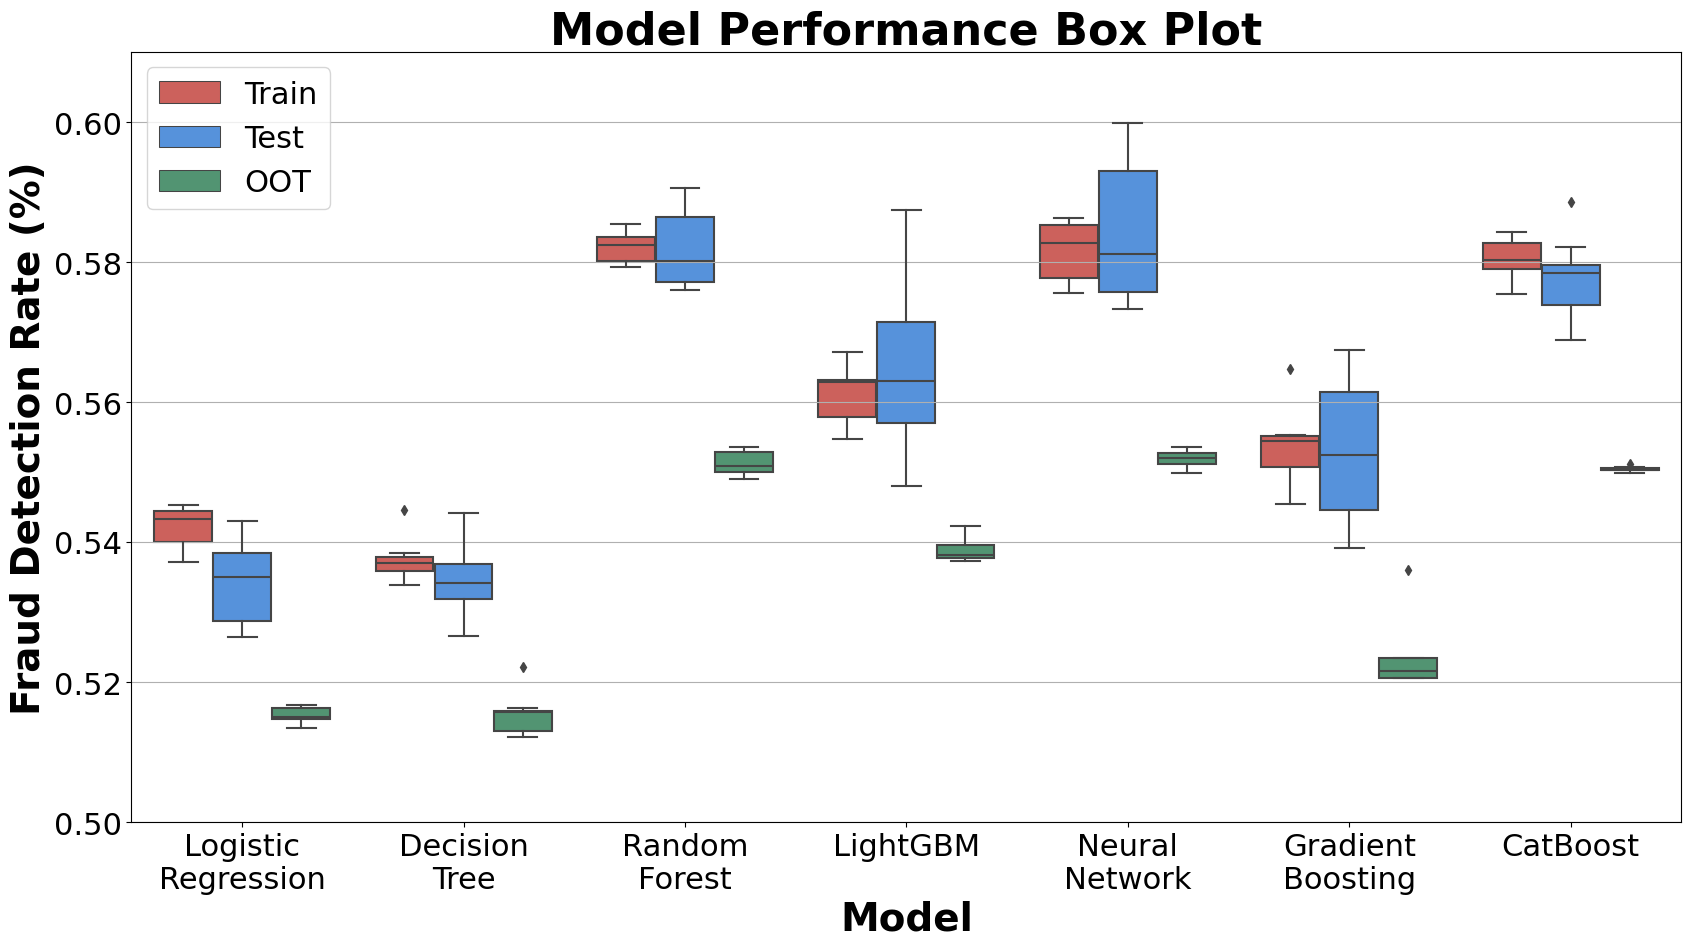

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['#DF5049', '#4090F1', '#479F71'])

plt.ylim(.5,.61)
plt.grid(axis='y')

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Model', fontsize=28, fontweight='bold')
plt.ylabel('Fraud Detection Rate (%)', fontsize=28, fontweight='bold')
plt.title('Model Performance Box Plot', fontsize=32,fontweight='bold')

ax = plt.gca()
legend = ax.legend(fontsize=22)
fig = plt.gcf()  # Get current figure
fig.set_facecolor('white')  # Set background color

plt.show()

In [40]:
%%time
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = RandomForestClassifier(n_estimators=50,
                                   max_depth=8,
                                   min_samples_split=50,
                                   min_samples_leaf=30,
                                   max_features = 10,
                                   criterion='entropy')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['fraud_label'] = Y_trn_save['fraud_label']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'fraud_label']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'fraud_label'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['fraud_label'] = Y_tst['fraud_label']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'fraud_label']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'fraud_label'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['fraud_label'] = Y_oot['fraud_label']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'fraud_label']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'fraud_label'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break

0 0.578991296053416 0.587292817679558 0.5498742665549036
1 0.5802003535651149 0.5911413969335605 0.5511316010058676
2 0.5823741007194244 0.5822197982001637 0.5515507124895223
3 0.5854848304580607 0.5735702387562466 0.5511316010058676
4 0.5778513961192617 0.5853727144866385 0.5477787091366303
5 0.5822216975563688 0.5845588235294118 0.5532271584241408
6 0.5823494335122242 0.5831032578685809 0.5532271584241408
7 0.580672168400909 0.586121777290181 0.5532271584241408
8 0.5833134399618047 0.580876274455773 0.5507124895222129
9 0.5841194029850746 0.5803964757709251 0.5532271584241408
10 0.5815307820299501 0.5864180350681881 0.5523889354568315
11 0.5801091858533112 0.5920134040770735 0.5523889354568315
12 0.5823130868893379 0.5829159710628826 0.5532271584241408
13 0.5859198477821382 0.575319622012229 0.5523889354568315
14 0.583700702966758 0.5802434975096845 0.5540653813914501
15 0.5824822780247507 0.5830618892508144 0.5507124895222129
16 0.584674055535693 0.5741150442477876 0.550712489522212

In [113]:
print(FDR3.mean())
# model_counter = model_counter + 1

trn    0.582688
tst    0.581996
oot    0.551844
dtype: float64


In [42]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [114]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'fraud_label'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'fraud_label'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'fraud_label'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,fulladdress_day_since,address_count_14,address_count_7,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_fullname_30,address_unique_count_for_fullname_homephone_3,ssn_fullname_count_30,zip5_unique_count_for_fullname_homephone_3,ssn_lastname_count_0_by_30,homephone_unique_count_for_ssn_zip5_7,fulladdress_homephone_unique_count_for_ssn_firstname_60,ssn_unique_count_for_fulladdress_homephone_60,ssn_dob_unique_count_for_fullname_homephone_60,ssn_lastname_unique_count_for_zip5_60,predicted,fraud_label
878000,-3.280209,22.562122,23.826715,19.854108,19.925712,22.962572,25.805911,-0.097936,8.614300,0.171723,0.061985,-0.046327,-0.053384,-0.046628,-0.045034,1.0,1
971938,-3.280209,16.090484,16.998315,14.154360,14.206612,16.384768,18.417057,-0.097936,5.931144,0.171723,7.523641,20.803866,-0.053384,-0.046628,-0.045034,1.0,1
845025,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,19.941388,-0.776746,-9.072502,-0.767088,-0.046327,19.258505,21.278720,21.327307,1.0,1
892776,-3.280209,16.090484,16.998315,14.154360,14.206612,16.384768,18.417057,-0.097936,7.272722,0.171723,7.523641,20.803866,-0.053384,-0.046628,-0.045034,1.0,0
914915,-3.280209,27.415850,27.240914,25.553856,25.644812,27.895925,25.805911,-0.097936,8.614300,0.171723,5.865495,16.633827,1.877805,-0.046628,-0.045034,1.0,1
996280,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,33.968916,-0.776746,-9.243691,0.061985,-0.046327,32.776828,36.206464,36.287946,1.0,1
948787,-3.280209,17.708394,18.705415,14.154360,14.206612,16.384768,18.417057,1.905996,5.931144,-5.477525,-0.767088,-0.046327,-0.053384,-0.046628,-0.045034,1.0,1
942033,0.403033,-0.088610,-0.072683,-0.095009,-0.091137,-0.059743,-0.055078,23.949253,-0.776746,-9.388543,-0.767088,-0.046327,23.120883,25.543790,25.601775,1.0,1
971640,-3.280209,14.472575,15.291215,12.729423,12.776838,14.740317,16.569844,-0.097936,5.260355,0.171723,6.694568,18.718847,-0.053384,-0.046628,-0.045034,1.0,1
881608,-3.280209,25.797940,27.240914,22.703982,22.785262,26.251474,29.500338,-0.097936,9.955878,0.171723,14.156224,33.313982,-0.053384,-0.046628,-0.045034,1.0,1


In [115]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'fraud_label'])
    num_bad_tst = sum(temp_tst.loc[:,'fraud_label'])
    num_bad_oot = sum(temp_oot.loc[:,'fraud_label'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,473.0,1192.0,28.408408,71.591592,1665.0,473.0,1192.0,0.288227,49.958089,49.669862,0.396812
2,2.0,1665.0,1569.0,96.0,94.234234,5.765766,3330.0,2042.0,1288.0,1.244310,53.981559,52.737249,1.585404
3,3.0,1665.0,1639.0,26.0,98.438438,1.561562,4995.0,3681.0,1314.0,2.243049,55.071249,52.828200,2.801370
4,4.0,1665.0,1645.0,20.0,98.798799,1.201201,6660.0,5326.0,1334.0,3.245444,55.909472,52.664028,3.992504
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1659.0,6.0,99.639640,0.360360,159833.0,157485.0,2348.0,95.964828,98.407376,2.442549,67.071976
97,97.0,1665.0,1655.0,10.0,99.399399,0.600601,161498.0,159140.0,2358.0,96.973316,98.826488,1.853172,67.489398
98,98.0,1665.0,1655.0,10.0,99.399399,0.600601,163163.0,160795.0,2368.0,97.981805,99.245599,1.263795,67.903294
99,99.0,1665.0,1657.0,8.0,99.519520,0.480480,164828.0,162452.0,2376.0,98.991512,99.580889,0.589377,68.372054


In [116]:
FDR3.to_csv('FDR3.csv')
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

Max possible savings: $34,919,012.56


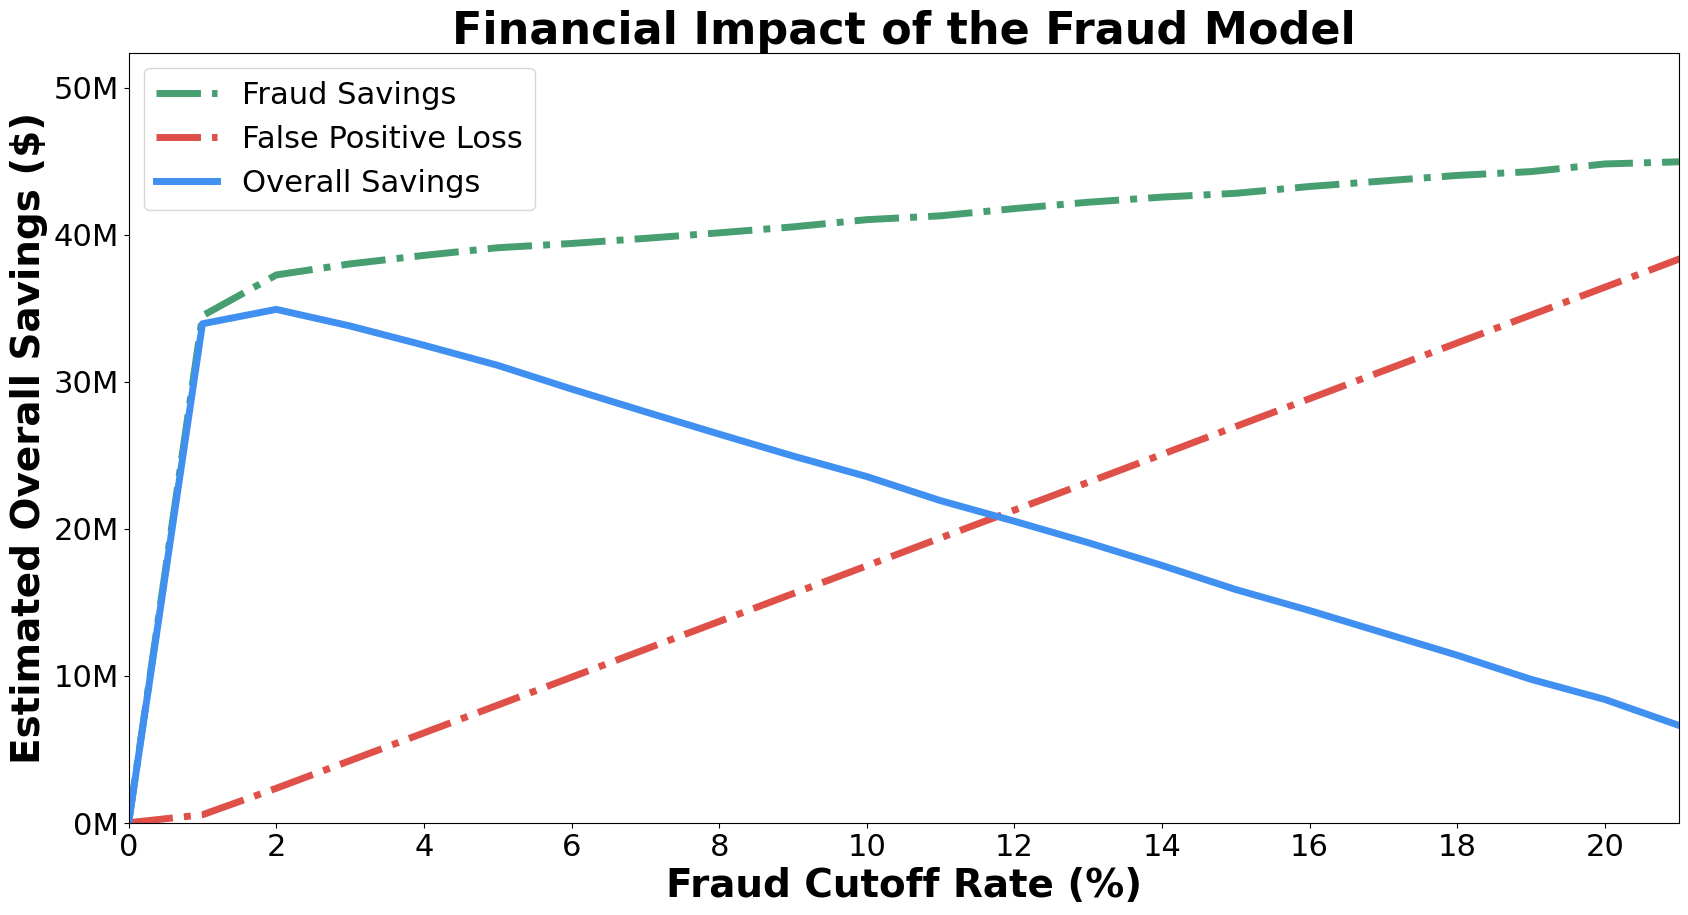

In [160]:
cost_fraud = 28930
cost_fp = 1500*12*(0.03+0.22/12*0.51*0.2)*2
import matplotlib.ticker as ticker

# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 1000000/(1000000-833507) * 100_000_000/1_000_000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud 
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp 
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'${:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.figure(figsize=(20,10))
plt.plot(Financials_oot['Fraud Savings'], color='#479F71', label = 'Fraud Savings', linewidth = 5, linestyle = '-.')
plt.plot(Financials_oot['FP Loss'], color='#DF5049', label = 'False Positive Loss', linewidth = 5, linestyle = '-.')
plt.plot(Financials_oot['Overall Savings'], color='#4090F1', label = 'Overall Savings', linewidth = 5)
# Set tick format to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return f'{x*1e-6:1.0f}M'

formatter = ticker.FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlim(0,21)
plt.xticks(range(0,21,2))
plt.ylim(0,yupper)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Fraud Cutoff Rate (%)', fontsize=28, fontweight='bold')
plt.ylabel('Estimated Overall Savings ($)', fontsize=28, fontweight='bold')
plt.title('Financial Impact of the Fraud Model', fontsize=32,fontweight='bold')
ax = plt.gca()
legend = ax.legend(fontsize=22)
plt.savefig('savings.png', format='png')

In [157]:
cost_fp

573.66